In [1]:
import numpy as np
import matplotlib.pylab as pl
import ot
import ot.plot
from sklearn.decomposition import PCA, KernelPCA

# S1 = pfb.weights_model1
# S2 = pfb.weights_model2
# S = np.vstack([S1, S2])
# psa = PCA(n_components=2)
# psa.fit(S)
# xs = psa.transform(S1)
# xt = psa.transform(S2)
# n = len(pfb.weights_model1) # nb samples

# a, b = np.ones((n,)) / n, np.ones((n,)) / n  # uniform distribution on samples

# # loss matrix
# M = ot.dist(pfb.weights_model1, pfb.weights_model2)
# M /= M.max()

# pl.figure(1)
# pl.plot(xs[:, 0], xs[:, 1], '+b', label='Source samples')
# pl.plot(xt[:, 0], xt[:, 1], 'xr', label='Target samples')
# pl.legend(loc=0)
# pl.title('Source and target distributions')

# pl.figure(2)
# pl.imshow(M, interpolation='nearest')
# pl.title('Cost matrix M')

# G0 = ot.emd(a, b, M)

# pl.figure(3)
# pl.imshow(G0, interpolation='nearest')
# pl.title('OT matrix G0')

# pl.figure(4)
# ot.plot.plot2D_samples_mat(xs, xt, G0, c=[.5, .5, 1])
# pl.plot(xs[:, 0], xs[:, 1], '+b', label='Source samples')
# pl.plot(xt[:, 0], xt[:, 1], 'xr', label='Target samples')

# pl.legend(loc=0)
# pl.title('OT matrix with samples')

In [2]:
from point_finders import *

getting loaders
Files already downloaded and verified
You are going to run models on the test set. Are you sure?
Files already downloaded and verified
getting data
train len 50000 test len 10000


In [3]:
import models
model_name = 'Linear7NoBias'
architecture = getattr(models, model_name) #LinearOneLayer LogRegression

In [4]:
model1 = architecture.base(num_classes=10, **architecture.kwargs)
model2 = architecture.base(num_classes=10, **architecture.kwargs)
model1.load_state_dict(torch.load('curves/'+model_name+'/curve3/checkpoint-400.pt')['model_state'])
model2.load_state_dict(torch.load('curves/'+model_name+'/curve4/checkpoint-400.pt')['model_state'])

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [5]:
model1.cuda();
test_model(model1, loaders, cuda=True)

train results {'nll': 0.02027139685869217, 'loss': 0.02027139685869217, 'accuracy': 99.384}
test results {'nll': 2.9237209270477296, 'loss': 2.9237209270477296, 'accuracy': 60.97}


({'nll': 0.02027139685869217, 'loss': 0.02027139685869217, 'accuracy': 99.384},
 {'nll': 2.9237209270477296, 'loss': 2.9237209270477296, 'accuracy': 60.97})

In [6]:
model2.cuda();
test_model(model2, loaders, cuda=True)

train results {'nll': 0.022724376260638238, 'loss': 0.022724376260638238, 'accuracy': 99.356}
test results {'nll': 2.899928831100464, 'loss': 2.899928831100464, 'accuracy': 61.05}


({'nll': 0.022724376260638238,
  'loss': 0.022724376260638238,
  'accuracy': 99.356},
 {'nll': 2.899928831100464, 'loss': 2.899928831100464, 'accuracy': 61.05})

In [9]:
depth = 7

In [10]:
# N_data = 10 #6144
# data, targ = data[:N_data], targ[:N_data]

In [11]:
get_end_point_stat(architecture, model_name, beg_ind=3, end_ind=5)

 50%|█████     | 1/2 [00:06<00:06,  6.93s/it]

train results {'nll': 0.02027139685869217, 'loss': 0.02027139685869217, 'accuracy': 99.384}
test results {'nll': 2.9237209270477296, 'loss': 2.9237209270477296, 'accuracy': 60.97}


100%|██████████| 2/2 [00:13<00:00,  6.91s/it]

train results {'nll': 0.022724376260638238, 'loss': 0.022724376260638238, 'accuracy': 99.356}
test results {'nll': 2.899928831100464, 'loss': 2.899928831100464, 'accuracy': 61.05}


{'train': [99.384, 99.356], 'test': [60.97, 61.05]}

In [12]:
class PointFinderStepWiseTransportation(PointFinderStepWiseButterfly):
    def __init__(self, model1, model2, architecture):
        super().__init__(model1, model2, architecture)
        self.GO = []
        self.M = []
        
    def solve_optimal_transport_problem(self, weights1, weights2):
        n = len(weights1) 
        a, b = np.ones((n,)) / n, np.ones((n,)) / n  # uniform distribution on samples
        # loss matrix
        M = ot.dist(weights1, weights2)
        M /= M.max()
        self.M.append(M)
        GO = ot.emd(a, b, M)
        self.GO.append(GO)
        return GO
    
    def butterfly_weights(self, W1, W2):
        samples = np.hstack([W1, W2.T])
        return samples
    
    def unbutterfly_weights(self, samples, l1):
        Wn0 = samples[:, :l1] 
        Wn1 = samples[:, l1:].T 
        return Wn0, Wn1
    
    def test_one_zeroing(self, layer):
        print('testing one zeroing, layer', layer)
        Wn0 = self.weights_model2[layer]
        Wn1 = self.weights_adjusted[layer + 1]
        Wn0[0] = 0
        Wn1[:, 0] = 0
        weights_model_t = self.weights_model2[:layer] + [Wn0, Wn1] + self.weights_model1[layer + 2:]
        
        m = get_model_from_weights(weights_model_t, self.architecture)
        m.cuda();
        res = test_model(m, loaders, cuda=True)
        out = {'train': res[0]['accuracy'], 'test': res[1]['accuracy']}
        return out
    
    def test_zeroing(self):
        out = {'train': [], 'test': []}
        for layer in range(self.depth-1):
            res = self.test_one_zeroing(layer)
            out['train'].append(res['train'])
            out['test'].append(res['test'])
        self.zeroing_stat = out
        out['train'] = np.min(out['train'])
        out['test'] = np.min(out['test'])
        return out
        
    def find_point(self, t=0.5, method='lin_connect'):

        layer = int(t // 1)
        t = t - layer
        if layer >= self.depth - 1:
            layer = self.depth - 2
            t = 1

        assert layer < self.depth, 'the network is shot for this t value'
        W11 = self.weights_model1[layer + 1]
        W20 = self.weights_model2[layer]
        W10 = self.weights_adjusted[layer]
        W11b2 = self.weights_adjusted[layer + 1]
        weights1 = self.butterfly_weights(W10, W11)
        weights2 = self.butterfly_weights(W20, W11b2)
        GO = self.solve_optimal_transport_problem(weights1, weights2)
        indices = np.argmax(GO, axis=-1)
        weights2_permuted = weights2[indices]
        weights_model_new = getattr(Connector(weights1, weights2_permuted), method)(t=t)[1]
        Wn0, Wn1 = self.unbutterfly_weights(weights_model_new, len(W10.T))
        weights_model_t = self.weights_model2[:layer] + [Wn0, Wn1] + self.weights_model1[layer + 2:]
        
        m = get_model_from_weights(weights_model_t, self.architecture)
        m.cuda();
        res = test_model(m, loaders, cuda=True)
        out = {'train': res[0]['accuracy'], 'test': res[1]['accuracy']}
        return out


In [13]:
pfswt = PointFinderStepWiseTransportation(model1, model2, architecture)

  0%|          | 0/5 [00:00<?, ?it/s]

finding feature maps


  0%|          | 0/5 [00:00<?, ?it/s]

finding feature maps


100%|██████████| 5/5 [00:08<00:00,  1.62s/it]
0it [00:00, ?it/s]

adjusting weights


5it [04:25, 59.99s/it] 


In [14]:
time = np.linspace(0, 6, 61)
time

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
       2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8,
       3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1,
       5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. ])

In [15]:
path_trl = find_path(time, pfswt, method='lin_connect')

  0%|          | 0/61 [00:00<?, ?it/s]/home/ivan/.local/lib/python3.6/site-packages/ot/lp/__init__.py:113: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
  2%|▏         | 1/61 [00:12<12:07, 12.13s/it]

train results {'nll': 0.02027139685869217, 'loss': 0.02027139685869217, 'accuracy': 99.384}
test results {'nll': 2.9237209270477296, 'loss': 2.9237209270477296, 'accuracy': 60.97}


/home/ivan/.local/lib/python3.6/site-packages/ot/lp/__init__.py:113: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
  3%|▎         | 2/61 [00:24<11:56, 12.14s/it]

train results {'nll': 0.021409193603992464, 'loss': 0.021409193603992464, 'accuracy': 99.372}
test results {'nll': 2.837782989883423, 'loss': 2.837782989883423, 'accuracy': 60.97}


/home/ivan/.local/lib/python3.6/site-packages/ot/lp/__init__.py:113: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
  5%|▍         | 3/61 [00:36<11:44, 12.14s/it]

train results {'nll': 0.023584390919804573, 'loss': 0.023584390919804573, 'accuracy': 99.316}
test results {'nll': 2.779083687210083, 'loss': 2.779083687210083, 'accuracy': 60.95}


/home/ivan/.local/lib/python3.6/site-packages/ot/lp/__init__.py:113: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
  7%|▋         | 4/61 [00:48<11:34, 12.18s/it]

train results {'nll': 0.02627561551272869, 'loss': 0.02627561551272869, 'accuracy': 99.224}
test results {'nll': 2.7416775424957276, 'loss': 2.7416775424957276, 'accuracy': 60.8}


/home/ivan/.local/lib/python3.6/site-packages/ot/lp/__init__.py:113: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
  8%|▊         | 5/61 [01:01<11:24, 12.22s/it]

train results {'nll': 0.028684038056731222, 'loss': 0.028684038056731222, 'accuracy': 99.148}
test results {'nll': 2.720931830215454, 'loss': 2.720931830215454, 'accuracy': 60.8}


/home/ivan/.local/lib/python3.6/site-packages/ot/lp/__init__.py:113: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
 10%|▉         | 6/61 [01:13<11:12, 12.22s/it]

train results {'nll': 0.029912945142388344, 'loss': 0.029912945142388344, 'accuracy': 99.094}
test results {'nll': 2.71381972694397, 'loss': 2.71381972694397, 'accuracy': 60.88}


/home/ivan/.local/lib/python3.6/site-packages/ot/lp/__init__.py:113: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
 11%|█▏        | 7/61 [01:25<10:58, 12.20s/it]

train results {'nll': 0.029495637340545656, 'loss': 0.029495637340545656, 'accuracy': 99.102}
test results {'nll': 2.719838575744629, 'loss': 2.719838575744629, 'accuracy': 60.76}


/home/ivan/.local/lib/python3.6/site-packages/ot/lp/__init__.py:113: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
 13%|█▎        | 8/61 [01:37<10:46, 12.20s/it]

train results {'nll': 0.02768929915845394, 'loss': 0.02768929915845394, 'accuracy': 99.174}
test results {'nll': 2.7413475875854494, 'loss': 2.7413475875854494, 'accuracy': 60.87}


/home/ivan/.local/lib/python3.6/site-packages/ot/lp/__init__.py:113: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
 15%|█▍        | 9/61 [01:49<10:35, 12.21s/it]

train results {'nll': 0.025216151416897772, 'loss': 0.025216151416897772, 'accuracy': 99.254}
test results {'nll': 2.7789297454833983, 'loss': 2.7789297454833983, 'accuracy': 61.03}


/home/ivan/.local/lib/python3.6/site-packages/ot/lp/__init__.py:113: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
 16%|█▋        | 10/61 [02:02<10:24, 12.24s/it]

train results {'nll': 0.022993406769037248, 'loss': 0.022993406769037248, 'accuracy': 99.326}
test results {'nll': 2.835988326263428, 'loss': 2.835988326263428, 'accuracy': 60.91}


 18%|█▊        | 11/61 [02:10<09:06, 10.93s/it]

train results {'nll': 0.021782094185352326, 'loss': 0.021782094185352326, 'accuracy': 99.368}
test results {'nll': 2.917767600250244, 'loss': 2.917767600250244, 'accuracy': 60.95}


 20%|█▉        | 12/61 [02:17<08:10, 10.01s/it]

train results {'nll': 0.1278260725927353, 'loss': 0.1278260725927353, 'accuracy': 97.716}
test results {'nll': 2.7279181423187255, 'loss': 2.7279181423187255, 'accuracy': 60.46}


 21%|██▏       | 13/61 [02:25<07:27,  9.32s/it]

train results {'nll': 0.22242576234817504, 'loss': 0.22242576234817504, 'accuracy': 96.442}
test results {'nll': 2.594879341888428, 'loss': 2.594879341888428, 'accuracy': 59.9}


 23%|██▎       | 14/61 [02:33<06:55,  8.85s/it]

train results {'nll': 0.28016691482543943, 'loss': 0.28016691482543943, 'accuracy': 95.096}
test results {'nll': 2.4909541816711425, 'loss': 2.4909541816711425, 'accuracy': 59.47}


 25%|██▍       | 15/61 [02:41<06:31,  8.52s/it]

train results {'nll': 0.3182644671726227, 'loss': 0.3182644671726227, 'accuracy': 93.694}
test results {'nll': 2.413017916870117, 'loss': 2.413017916870117, 'accuracy': 59.3}


 26%|██▌       | 16/61 [02:48<06:14,  8.32s/it]

train results {'nll': 0.3277843031406403, 'loss': 0.3277843031406403, 'accuracy': 92.596}
test results {'nll': 2.358389246368408, 'loss': 2.358389246368408, 'accuracy': 59.02}


 28%|██▊       | 17/61 [02:56<05:58,  8.14s/it]

train results {'nll': 0.2990291888809204, 'loss': 0.2990291888809204, 'accuracy': 92.54}
test results {'nll': 2.3212865547180175, 'loss': 2.3212865547180175, 'accuracy': 59.43}


 30%|██▉       | 18/61 [03:04<05:45,  8.04s/it]

train results {'nll': 0.23667132732391358, 'loss': 0.23667132732391358, 'accuracy': 93.366}
test results {'nll': 2.3170402252197264, 'loss': 2.3170402252197264, 'accuracy': 60.02}


 31%|███       | 19/61 [03:12<05:35,  7.98s/it]

train results {'nll': 0.1668635315799713, 'loss': 0.1668635315799713, 'accuracy': 94.498}
test results {'nll': 2.3720896278381347, 'loss': 2.3720896278381347, 'accuracy': 60.33}


 33%|███▎      | 20/61 [03:20<05:25,  7.93s/it]

train results {'nll': 0.13156139566659927, 'loss': 0.13156139566659927, 'accuracy': 95.428}
test results {'nll': 2.5062075229644774, 'loss': 2.5062075229644774, 'accuracy': 60.77}


 34%|███▍      | 21/61 [03:27<05:07,  7.69s/it]

train results {'nll': 0.12763441480875015, 'loss': 0.12763441480875015, 'accuracy': 95.664}
test results {'nll': 2.735128133392334, 'loss': 2.735128133392334, 'accuracy': 60.69}


 36%|███▌      | 22/61 [03:34<04:51,  7.48s/it]

train results {'nll': 0.14678273515701293, 'loss': 0.14678273515701293, 'accuracy': 94.94}
test results {'nll': 2.3293127670288087, 'loss': 2.3293127670288087, 'accuracy': 60.84}


 38%|███▊      | 23/61 [03:41<04:39,  7.36s/it]

train results {'nll': 0.2050318616771698, 'loss': 0.2050318616771698, 'accuracy': 92.828}
test results {'nll': 2.0525605182647704, 'loss': 2.0525605182647704, 'accuracy': 60.49}


 39%|███▉      | 24/61 [03:48<04:28,  7.26s/it]

train results {'nll': 0.2980232878780365, 'loss': 0.2980232878780365, 'accuracy': 89.59}
test results {'nll': 1.8800542394638062, 'loss': 1.8800542394638062, 'accuracy': 59.88}


 41%|████      | 25/61 [03:55<04:19,  7.20s/it]

train results {'nll': 0.3990088317203522, 'loss': 0.3990088317203522, 'accuracy': 86.064}
test results {'nll': 1.7789380952835083, 'loss': 1.7789380952835083, 'accuracy': 59.46}


 43%|████▎     | 26/61 [04:02<04:10,  7.16s/it]

train results {'nll': 0.4654298206710815, 'loss': 0.4654298206710815, 'accuracy': 83.934}
test results {'nll': 1.72539715423584, 'loss': 1.72539715423584, 'accuracy': 59.15}


 44%|████▍     | 27/61 [04:09<04:02,  7.15s/it]

train results {'nll': 0.4768267735290527, 'loss': 0.4768267735290527, 'accuracy': 83.504}
test results {'nll': 1.7077507928848266, 'loss': 1.7077507928848266, 'accuracy': 59.31}


 46%|████▌     | 28/61 [04:16<03:55,  7.13s/it]

train results {'nll': 0.4458059111881256, 'loss': 0.4458059111881256, 'accuracy': 84.678}
test results {'nll': 1.7268637853622437, 'loss': 1.7268637853622437, 'accuracy': 59.89}


 48%|████▊     | 29/61 [04:23<03:48,  7.13s/it]

train results {'nll': 0.4004678656959534, 'loss': 0.4004678656959534, 'accuracy': 86.164}
test results {'nll': 1.7972159685134887, 'loss': 1.7972159685134887, 'accuracy': 60.58}


 49%|████▉     | 30/61 [04:30<03:40,  7.11s/it]

train results {'nll': 0.3698246639251709, 'loss': 0.3698246639251709, 'accuracy': 87.226}
test results {'nll': 1.938763835144043, 'loss': 1.938763835144043, 'accuracy': 60.71}


 51%|█████     | 31/61 [04:37<03:31,  7.04s/it]

train results {'nll': 0.37502390303611755, 'loss': 0.37502390303611755, 'accuracy': 87.668}
test results {'nll': 2.177590302658081, 'loss': 2.177590302658081, 'accuracy': 60.65}


 52%|█████▏    | 32/61 [04:44<03:23,  7.01s/it]

train results {'nll': 0.3413470887184143, 'loss': 0.3413470887184143, 'accuracy': 88.28}
test results {'nll': 1.9436666458129883, 'loss': 1.9436666458129883, 'accuracy': 60.89}


 54%|█████▍    | 33/61 [04:51<03:16,  7.00s/it]

train results {'nll': 0.31446670482635497, 'loss': 0.31446670482635497, 'accuracy': 89.02}
test results {'nll': 1.7790951044082641, 'loss': 1.7790951044082641, 'accuracy': 61.14}


 56%|█████▌    | 34/61 [04:58<03:09,  7.00s/it]

train results {'nll': 0.28447018510818484, 'loss': 0.28447018510818484, 'accuracy': 90.178}
test results {'nll': 1.6805808376312257, 'loss': 1.6805808376312257, 'accuracy': 61.37}


 57%|█████▋    | 35/61 [05:05<03:02,  7.00s/it]

train results {'nll': 0.24434209814071656, 'loss': 0.24434209814071656, 'accuracy': 91.74}
test results {'nll': 1.6448082540512086, 'loss': 1.6448082540512086, 'accuracy': 61.34}


 59%|█████▉    | 36/61 [05:12<02:54,  7.00s/it]

train results {'nll': 0.19484073674201965, 'loss': 0.19484073674201965, 'accuracy': 93.648}
test results {'nll': 1.671316189956665, 'loss': 1.671316189956665, 'accuracy': 61.67}


 61%|██████    | 37/61 [05:19<02:47,  6.99s/it]

train results {'nll': 0.14477335588932036, 'loss': 0.14477335588932036, 'accuracy': 95.408}
test results {'nll': 1.7610531042098998, 'loss': 1.7610531042098998, 'accuracy': 61.93}


 62%|██████▏   | 38/61 [05:26<02:40,  6.96s/it]

train results {'nll': 0.10405006152391434, 'loss': 0.10405006152391434, 'accuracy': 96.726}
test results {'nll': 1.9152066627502442, 'loss': 1.9152066627502442, 'accuracy': 62.08}


 64%|██████▍   | 39/61 [05:33<02:32,  6.94s/it]

train results {'nll': 0.07715338457584381, 'loss': 0.07715338457584381, 'accuracy': 97.552}
test results {'nll': 2.13096732711792, 'loss': 2.13096732711792, 'accuracy': 61.91}


 66%|██████▌   | 40/61 [05:40<02:25,  6.94s/it]

train results {'nll': 0.06293855108976364, 'loss': 0.06293855108976364, 'accuracy': 97.97}
test results {'nll': 2.403684567260742, 'loss': 2.403684567260742, 'accuracy': 61.82}


 67%|██████▋   | 41/61 [05:47<02:18,  6.93s/it]

train results {'nll': 0.05839925897359848, 'loss': 0.05839925897359848, 'accuracy': 98.104}
test results {'nll': 2.729659860610962, 'loss': 2.729659860610962, 'accuracy': 61.68}


 69%|██████▉   | 42/61 [05:54<02:11,  6.92s/it]

train results {'nll': 0.06258322205066681, 'loss': 0.06258322205066681, 'accuracy': 98.034}
test results {'nll': 3.591412631225586, 'loss': 3.591412631225586, 'accuracy': 61.65}


 70%|███████   | 43/61 [06:01<02:05,  6.96s/it]

train results {'nll': 0.07047747588396072, 'loss': 0.07047747588396072, 'accuracy': 97.928}
test results {'nll': 4.285108560180664, 'loss': 4.285108560180664, 'accuracy': 61.5}


 72%|███████▏  | 44/61 [06:08<01:57,  6.94s/it]

train results {'nll': 0.07578913475990295, 'loss': 0.07578913475990295, 'accuracy': 97.922}
test results {'nll': 4.777217640686035, 'loss': 4.777217640686035, 'accuracy': 61.36}


 74%|███████▍  | 45/61 [06:15<01:51,  6.94s/it]

train results {'nll': 0.07681496725082397, 'loss': 0.07681496725082397, 'accuracy': 97.984}
test results {'nll': 5.053751119232178, 'loss': 5.053751119232178, 'accuracy': 61.34}


 75%|███████▌  | 46/61 [06:22<01:44,  6.95s/it]

train results {'nll': 0.07310999284982682, 'loss': 0.07310999284982682, 'accuracy': 98.104}
test results {'nll': 5.110527430725098, 'loss': 5.110527430725098, 'accuracy': 61.48}


 77%|███████▋  | 47/61 [06:29<01:37,  6.97s/it]

train results {'nll': 0.06533958672523499, 'loss': 0.06533958672523499, 'accuracy': 98.274}
test results {'nll': 4.947825259399414, 'loss': 4.947825259399414, 'accuracy': 61.5}


 79%|███████▊  | 48/61 [06:35<01:30,  6.94s/it]

train results {'nll': 0.054766805814504625, 'loss': 0.054766805814504625, 'accuracy': 98.466}
test results {'nll': 4.5718963493347164, 'loss': 4.5718963493347164, 'accuracy': 61.62}


 80%|████████  | 49/61 [06:42<01:23,  6.95s/it]

train results {'nll': 0.04327664829969406, 'loss': 0.04327664829969406, 'accuracy': 98.696}
test results {'nll': 4.012665299224854, 'loss': 4.012665299224854, 'accuracy': 61.81}


 82%|████████▏ | 50/61 [06:49<01:16,  6.95s/it]

train results {'nll': 0.034184628450274465, 'loss': 0.034184628450274465, 'accuracy': 98.94}
test results {'nll': 3.3644293632507325, 'loss': 3.3644293632507325, 'accuracy': 61.97}


 84%|████████▎ | 51/61 [06:56<01:09,  6.97s/it]

train results {'nll': 0.03092817055761814, 'loss': 0.03092817055761814, 'accuracy': 99.068}
test results {'nll': 2.7973120079040528, 'loss': 2.7973120079040528, 'accuracy': 61.65}


 85%|████████▌ | 52/61 [07:03<01:02,  6.97s/it]

train results {'nll': 0.02949520364165306, 'loss': 0.02949520364165306, 'accuracy': 99.114}
test results {'nll': 2.7106806674957276, 'loss': 2.7106806674957276, 'accuracy': 61.81}


 87%|████████▋ | 53/61 [07:10<00:55,  6.98s/it]

train results {'nll': 0.028208071210980415, 'loss': 0.028208071210980415, 'accuracy': 99.174}
test results {'nll': 2.6451556465148927, 'loss': 2.6451556465148927, 'accuracy': 61.79}


 89%|████████▊ | 54/61 [07:17<00:49,  7.00s/it]

train results {'nll': 0.02706032864630222, 'loss': 0.02706032864630222, 'accuracy': 99.218}
test results {'nll': 2.601340811920166, 'loss': 2.601340811920166, 'accuracy': 61.75}


 90%|█████████ | 55/61 [07:24<00:42,  7.01s/it]

train results {'nll': 0.02604700124025345, 'loss': 0.02604700124025345, 'accuracy': 99.25}
test results {'nll': 2.5794149253845213, 'loss': 2.5794149253845213, 'accuracy': 61.73}


 92%|█████████▏| 56/61 [07:31<00:35,  7.01s/it]

train results {'nll': 0.02516430973768234, 'loss': 0.02516430973768234, 'accuracy': 99.298}
test results {'nll': 2.579377460861206, 'loss': 2.579377460861206, 'accuracy': 61.71}


 93%|█████████▎| 57/61 [07:38<00:28,  7.00s/it]

train results {'nll': 0.024408908057808876, 'loss': 0.024408908057808876, 'accuracy': 99.322}
test results {'nll': 2.6011838466644286, 'loss': 2.6011838466644286, 'accuracy': 61.43}


 95%|█████████▌| 58/61 [07:45<00:20,  7.00s/it]

train results {'nll': 0.0237810778683424, 'loss': 0.0237810778683424, 'accuracy': 99.35}
test results {'nll': 2.6446086921691894, 'loss': 2.6446086921691894, 'accuracy': 61.35}


 97%|█████████▋| 59/61 [07:52<00:14,  7.02s/it]

train results {'nll': 0.023286706083416937, 'loss': 0.023286706083416937, 'accuracy': 99.35}
test results {'nll': 2.709284088897705, 'loss': 2.709284088897705, 'accuracy': 61.23}


 98%|█████████▊| 60/61 [07:59<00:07,  7.02s/it]

train results {'nll': 0.02293143329143524, 'loss': 0.02293143329143524, 'accuracy': 99.354}
test results {'nll': 2.794696636199951, 'loss': 2.794696636199951, 'accuracy': 61.19}


100%|██████████| 61/61 [08:07<00:00,  7.02s/it]

train results {'nll': 0.02272437646448612, 'loss': 0.02272437646448612, 'accuracy': 99.356}
test results {'nll': 2.8999288555145264, 'loss': 2.8999288555145264, 'accuracy': 61.05}


In [20]:
time[25]

2.5

In [22]:
time[np.argmax(np.array(path_trl['train']))], time[np.argmax(np.array(path_trl['test']))]

(2.6, 1.5)

In [17]:
path_trl['train'][np.argmax(np.array(path_trl['train']))] - path_trl['train'][25]

0.4299999999999926

In [18]:
path_trl['test'][np.argmax(np.array(path_trl['test']))] - path_trl['test'][25]

0.12999999999999545

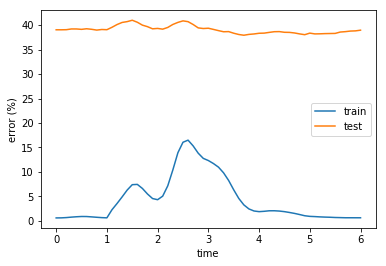

In [19]:
plt.plot(time, path_trl['train'], label='train')
plt.plot(time, path_trl['test'], label='test') 
plt.legend()
plt.xlabel('time')
plt.ylabel('error (%)')
plt.show()

In [ ]:
stat = get_stat_plus_zeroing(PointFinderStepWiseTransportation, model_name, architecture, t=2.5, method='lin_connect',
             beg_ind=1, end_ind=7)


  0%|          | 0/5 [00:00<?, ?it/s]

finding feature maps



100%|██████████| 5/5 [00:08<00:00,  1.61s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

finding feature maps



100%|██████████| 5/5 [00:08<00:00,  1.62s/it]

0it [00:00, ?it/s]

adjusting weights


In [28]:
stat_prl, stat_zero = stat

In [29]:
get_mean_svd(stat_prl)

(84.16166666666668, 0.28341587033113363, 59.895, 0.4480606357774961)

In [30]:
# stat_zero = test_zeroing(PointFinderStepWiseTransportation, model_name, architecture, beg_ind=3, end_ind=10)

In [31]:
get_mean_svd(stat_zero)

(87.34066666666666,
 0.25194091017979175,
 60.57333333333333,
 0.15744487571492685)